# Imports

In [1]:
from sklearn.metrics import auc
# import matlab.engine
import numpy as np
import numpy.matlib
import pickle
import sys
from scipy.io import loadmat
from os.path import exists
from scipy.signal import resample
import pgmpy
import pandas as pd
from AicScore import AicScore
from pgmpy.estimators import HillClimbSearch
from statsmodels.stats.proportion import proportions_ztest
from time import time

# from EfficientTimeShuffling import EfficientShuffle

from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

import matplotlib.pyplot as plt

import matplotlib as mpl

# DBN Functions

In [2]:
def graph_to_matrix(edges):

    output_matrix = np.zeros((3,3)) # (3,3)
    
    column = 0
    for from_layer in np.arange(1,4,1): # np.arange(1,4,1)
        row = 0
        #Loop through the receiving nodes (the last timeslice of each population)
        for to_layer in np.arange(1,4,1): # np.arange(1,4,1)
            from_pop = 'L{from_layer}_t1'.format(from_layer = from_layer)
            to_pop = 'L{to_layer}_t2'.format(to_layer = to_layer)

            if (from_pop, to_pop) in edges:
                output_matrix[row,column] = 1
            else:
                output_matrix[row,column] = 0
            row+=1
        column+=1
                    
    return output_matrix

In [15]:
from_layer = 1
from_pop = 'L{from_layer}_t1'
from_pop

'L{from_layer}_t1'

In [4]:
#Load spike data

def run_dbn_single_trial(trial, binWidth = 1, shuffle = False, combine = False, lag = 1):
    all_spikes = loadmat('nsLaminar_Set_2.mat')['SPIKES']

    #Bin spikes
    trial_duration = 2000 #First epoch only
    hist_spikes = []
    for iNeuron,neuron in enumerate(all_spikes):
        counts, edges = np.histogram(neuron[trial], bins = np.arange(0,trial_duration+binWidth, binWidth))
        hist_spikes.append(counts)


    #Combine spikes from same population by either layer/class or layer only
    if combine:
        population_indices = [[0,15],[15,30],[30,45]]
        pop_type = 'layeronly'
    else:
        population_indices = [[0,10],[10,15],[15,25],[25,30],[30,40],[40,45]]
        pop_type = 'layerclass'


    all_pop_spikes = []
    for start,finish in population_indices:
        all_pop_spikes.append(np.any(hist_spikes[start:finish],axis = 0))
    all_pop_spikes = np.array(all_pop_spikes, dtype = int)


    lagged_spikes = np.vstack((all_pop_spikes[:,0:-lag],all_pop_spikes[:,lag:]))
    spikes_df = pd.DataFrame(lagged_spikes.T, columns = ['L1_t1','L2_t1','L3_t1', 'L1_t2', 'L2_t2', 'L3_t2'])

    if shuffle:
        spikes_df, df_shufflekeys = EfficientShuffle(spikes_df,seed = round(time()))

    all_pops = list(spikes_df.columns)
    from_pops = [pop for pop in all_pops if not pop.endswith('t2')]
    to_pops = [pop for pop in all_pops if pop.endswith('t2')]
    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
    hc = HillClimbSearch(spikes_df)

    model = hc.estimate(tabu_length= 7, max_indegree=None, white_list = causal_whitelist, scoring_method = AicScore(spikes_df))

    print(spikes_df)
    return graph_to_matrix(list(model.edges()))




In [6]:
## a test dataset
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
# create data sample with 9 random variables:
data = pd.DataFrame(np.random.randint(0, 5, size=(5000, 9)), columns=list('ABCDEFGHI'))
# add 10th dependent variable
data['J'] = data['A'] * data['B']
est = HillClimbSearch(data)
best_model = est.estimate(scoring_method=BicScore(data))
sorted(best_model.nodes())
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
best_model.edges()
data

  0%|          | 0/1000000 [00:00<?, ?it/s]

,A,B,C,D,E,F,G,H,I,J
0,0,3,4,3,1,2,2,2,0,0
1,4,1,0,2,3,1,0,1,4,4
2,1,1,0,0,3,3,2,2,4,1
3,4,4,3,3,0,1,1,1,0,16
4,4,3,4,3,4,3,2,1,2,12
...,...,...,...,...,...,...,...,...,...,...
4995,2,0,0,1,1,1,2,4,4,0
4996,2,1,2,0,3,3,4,4,0,2
4997,0,2,1,2,3,1,0,1,2,0
4998,3,2,1,4,1,4,1,0,0,6


In [7]:
graph_to_matrix(list(best_model.edges()))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

# Unshuffled Data DBN Search

In [8]:
nTrials = 100
nFromNodes = 3
nToNodes = 3
lag = 1
binWidth = 2

DAGs = np.zeros((nTrials, nFromNodes, nToNodes))
for trial in range(100):
    DAGs[trial,:,:] = run_dbn_single_trial(trial, combine = True, lag = lag, binWidth = binWidth)

  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      0
995      1      1      0      1      0      1
996      1      0      1      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      1
1        0      0      1      0      1      1
2        0      1      1      1      1      1
3        1      1      1      0      0      0
4        0      0      0      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      0
995      0      0      0      0      0      0
996      0      0      0      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      1      1
995      0      1      1      1      1      1
996      1      1      1      0      0      1
997      0      0      1      0      0      1
998      0      0      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      0      0
1        1      0      0      0      0      1
2        0      0      1      0      1      0
3        0      1      0      0      1      0
4        0      1      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      1      1      0
995      1      1      0      0      1      0
996      0      1      0      1      0      0
997      1      0      0      1      1      1
998      1      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      1      1
2        0      1      1      0      1      0
3        0      1      0      0      0      1
4        0      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      0      1      1      0
995      1      1      0      1      0      0
996      1      0      0      1      0      0
997      1      0      0      0      1      1
998      0      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      1      0      0      0
995      0      0      0      1      0      1
996      1      0      1      0      0      1
997      0      0      1      1      1      0
998      1      1      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      1      0      0      1
1        0      0      1      1      0      1
2        1      0      1      1      0      0
3        1      0      0      1      1      1
4        1      1      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      0
995      0      0      0      0      0      0
996      0      0      0      1      1      1
997      1      1      1      0      0      0
998      0      0      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      0      0
3        0      0      0      0      1      0
4        0      1      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      1      0
995      0      1      0      0      1      0
996      0      1      0      1      0      1
997      1      0      1      0      0      1
998      0      0      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      1
1        0      0      1      1      0      0
2        1      0      0      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      0
995      0      0      0      0      0      0
996      0      0      0      0      1      0
997      0      1      0      0      0      0
998      0      0      0      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      0      0      1
2        0      0      1      1      1      1
3        1      1      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      1
995      1      1      1      0      1      1
996      0      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      1      0
4        0      1      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      0      1
995      1      0      1      0      1      1
996      0      1      1      0      1      0
997      0      1      0      1      0      1
998      1      0      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      1      0
3        1      1      0      0      0      1
4        0      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      0      1
995      1      0      1      1      0      1
996      1      0      1      1      0      1
997      1      0      1      0      0      0
998      0      0      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      1      0      0
2        1      0      0      0      0      0
3        0      0      0      1      0      0
4        1      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      0
995      1      1      0      0      1      0
996      0      1      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      1      0
1        1      1      0      0      1      1
2        0      1      1      0      0      1
3        0      0      1      0      1      0
4        0      1      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      1      1
995      0      1      1      1      1      0
996      1      1      0      1      1      1
997      1      1      1      1      1      0
998      1      1      0      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      0      1      1
2        0      1      1      0      1      0
3        0      1      0      1      0      0
4        1      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      0      1      1
996      0      1      1      0      0      0
997      0      0      0      0      1      0
998      0      1      0      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      0      1      0
996      0      1      0      1      1      0
997      1      1      0      0      0      1
998      0      0      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      1      0      0
4        1      0      0      1      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      1      0
995      1      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      1      0
4        0      1      0      1      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      1      0
995      0      1      0      0      0      0
996      0      0      0      1      0      0
997      1      0      0      1      1      1
998      1      1      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      0      0
3        0      0      0      1      1      0
4        1      1      0      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      1      0      1
995      1      0      1      1      1      1
996      1      1      1      0      0      1
997      0      0      1      1      0      0
998      1      0      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      0      0      0
2        0      0      0      1      1      1
3        1      1      1      0      0      0
4        0      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      1      1      0
996      1      1      0      1      1      0
997      1      1      0      0      1      1
998      0      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      1      0      0
3        1      0      0      1      1      0
4        1      1      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      0      0
995      1      0      0      0      0      0
996      0      0      0      0      1      0
997      0      1      0      0      0      0
998      0      0      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      1      0      1      1      1
1        1      1      1      0      0      0
2        0      0      0      1      0      0
3        1      0      0      1      0      0
4        1      0      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      0
995      0      0      0      0      1      0
996      0      1      0      0      0      0
997      0      0      0      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      1      0      0
3        1      0      0      1      0      1
4        1      0      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      1
995      1      1      1      1      0      1
996      1      0      1      1      0      0
997      1      0      0      1      0      0
998      1      0      0      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      1      0      0
1        1      0      0      0      0      1
2        0      0      1      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      0      1
995      1      0      1      1      0      1
996      1      0      1      1      0      0
997      1      0      0      0      0      0
998      0      0      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      0      0
3        0      0      0      1      0      1
4        1      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      0      0      0
996      0      0      0      1      0      1
997      1      0      1      0      1      1
998      0      1      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      1      0
1        1      1      0      1      0      0
2        1      0      0      1      1      0
3        1      1      0      0      0      1
4        0      0      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      0      0
995      0      0      0      0      1      0
996      0      1      0      0      0      0
997      0      0      0      0      0      0
998      0      0      0      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      0      1
995      1      0      1      1      0      0
996      1      0      0      0      0      0
997      0      0      0      0      0      0
998      0      0      0      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      0      1      0
1        0      1      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      1      0      1
4        1      0      1      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      0      1
995      1      0      1      1      1      1
996      1      1      1      1      0      0
997      1      0      0      1      1      0
998      1      1      0      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      1      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      1      0
1        1      1      0      0      0      1
2        0      0      1      0      0      0
3        0      0      0      1      0      1
4        1      0      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      1      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      1      0      0
3        1      0      0      0      0      0
4        0      0      0      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      1      1      1
995      1      1      1      1      0      1
996      1      0      1      1      0      1
997      1      0      1      0      0      1
998      0      0      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      0      0      1
2        0      0      1      0      1      0
3        0      1      0      1      1      1
4        1      1      1      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      0      1
995      1      0      1      0      1      1
996      0      1      1      1      0      1
997      1      0      1      1      1      1
998      1      1      1      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      0      0      1
1        0      0      1      0      1      0
2        0      1      0      0      1      0
3        0      1      0      0      0      0
4        0      0      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      0      0      1      0      1
995      1      0      1      1      0      1
996      1      0      1      1      1      1
997      1      1      1      1      0      1
998      1      0      1      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      1      1      1
2        1      1      1      1      1      1
3        1      1      1      1      0      1
4        1      0      1      0      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      0      1
995      1      0      1      0      1      1
996      0      1      1      1      0      1
997      1      0      1      1      0      1
998      1      0      1      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      1      1      0      0
1        1      0      0      0      0      0
2        0      0      0      0      0      1
3        0      0      1      1      0      1
4        1      0      1      1      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      1      1
995      0      1      1      1      0      0
996      1      0      0      0      0      0
997      0      0      0      1      1      0
998      1      1      0      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      1
1        1      0      1      0      0      0
2        0      0      0      1      0      1
3        1      0      1      1      1      1
4        1      1      1      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      1      0
995      1      1      0      0      0      0
996      0      0      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      1      0      0      0      0
1        0      0      0      1      1      0
2        1      1      0      0      0      1
3        0      0      1      0      1      0
4        0      1      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      1      1
995      1      1      1      1      1      0
996      1      1      0      0      1      1
997      0      1      1      0      0      0
998      0      0      0      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      1      0      0      1      1
1        0      1      1      1      0      0
2        1      0      0      0      0      0
3        0      0      0      1      1      1
4        1      1      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      1      0      0      1
995      0      0      1      0      1      0
996      0      1      0      1      1      0
997      1      1      0      0      1      0
998      0      1      0      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      0      1
3        1      0      1      0      0      1
4        0      0      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      1      0
995      0      1      0      1      0      0
996      1      0      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      1      1      0
2        1      1      0      1      1      0
3        1      1      0      1      1      1
4        1      1      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      0      0      1
1        0      0      1      0      0      1
2        0      0      1      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      1      1      1      0
1        1      1      0      0      0      1
2        0      0      1      1      0      1
3        1      0      1      0      0      1
4        0      0      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      1      0
995      0      1      0      0      0      0
996      0      0      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      1      1      1
4        1      1      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      1      0
995      0      1      0      1      1      0
996      1      1      0      0      0      0
997      0      0      0      1      0      1
998      1      0      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      1      0
3        1      1      0      1      1      1
4        1      1      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      0      1
995      1      0      1      0      1      1
996      0      1      1      0      1      1
997      0      1      1      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      1
2        0      1      1      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      0      0
995      1      0      0      0      1      1
996      0      1      1      0      0      0
997      0      0      0      0      0      0
998      0      0      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      1
1        0      0      1      0      0      0
2        0      0      0      1      1      0
3        1      1      0      0      0      1
4        0      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      0      0      0      0
995      0      0      0      0      0      0
996      0      0      0      0      1      0
997      0      1      0      1      0      0
998      1      0      0      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      1
2        0      0      1      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      0      1
995      1      0      1      1      1      0
996      1      1      0      1      1      1
997      1      1      1      1      0      1
998      1      0      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      1      1      1      0
1        1      1      0      1      1      1
2        1      1      1      1      0      0
3        1      0      0      0      1      1
4        0      1      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      1      0
995      0      1      0      1      1      0
996      1      1      0      0      1      0
997      0      1      0      0      0      0
998      0      0      0      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      1      0      0      1      1
1        0      1      1      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      1
995      1      1      1      0      1      0
996      0      1      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      1      0      0
1        1      0      0      0      0      0
2        0      0      0      0      1      1
3        0      1      1      1      1      1
4        1      1      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      1      0      0      1      0      1
995      1      0      1      1      0      1
996      1      0      1      1      1      1
997      1      1      1      0      0      0
998      0      0      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      1      0
2        0      1      0      0      0      1
3        0      0      1      1      0      0
4        1      0      0      1      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      0      1
995      1      0      1      0      1      0
996      0      1      0      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      1
2        0      0      1      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      0      0
995      1      0      0      1      0      1
996      1      0      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      0      0      1
997      0      0      1      1      1      1
998      1      1      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      1      1      0
4        1      1      0      1      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      1      0
995      1      1      0      0      1      1
996      0      1      1      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      0      0
995      1      0      0      0      0      0
996      0      0      0      0      0      0
997      0      0      0      0      0      1
998      0      0      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      1      0      0
4        1      0      0      1      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      0      1      1
996      0      1      1      1      0      1
997      1      0      1      1      0      0
998      1      0      0      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      1      1      0
4        1      1      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      0      0
995      0      0      0      0      0      1
996      0      0      1      0      0      0
997      0      0      0      0      0      1
998      0      0      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      1      0
2        0      1      0      1      0      1
3        1      0      1      0      0      1
4        0      0      1      0      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      0      0      1      0
995      0      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      0      1
998      1      0      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      1
1        0      0      1      0      0      0
2        0      0      0      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      0      0
995      0      0      0      0      0      0
996      0      0      0      0      0      1
997      0      0      1      0      0      1
998      0      0      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      0      0      0
2        0      0      0      1      0      1
3        1      0      1      1      1      1
4        1      1      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      1      1      1
996      1      1      1      0      1      1
997      0      1      1      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      1      0      0
4        1      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      1      0      1
995      1      0      1      0      0      0
996      0      0      0      0      0      0
997      0      0      0      0      0      0
998      0      0      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      0      0
995      0      0      0      0      1      1
996      0      1      1      0      0      0
997      0      0      0      0      0      0
998      0      0      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      0      0      1      0
995      0      1      0      1      0      0
996      1      0      0      1      1      1
997      1      1      1      0      0      1
998      0      0      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      1      0      0      0
1        0      0      0      0      1      0
2        0      1      0      1      0      0
3        1      0      0      0      0      1
4        0      0      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      0
995      1      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      0      1      1
998      0      1      1      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      1      1
3        1      1      1      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      1
995      0      0      1      0      0      0
996      0      0      0      0      0      0
997      0      0      0      0      0      0
998      0      0      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      0      1
1        1      0      1      0      1      0
2        0      1      0      0      0      1
3        0      0      1      0      0      1
4        0      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      1
995      0      0      1      1      0      0
996      1      0      0      1      0      1
997      1      0      1      0      1      0
998      0      1      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      1      0      1      1      1
1        1      1      1      1      0      1
2        1      0      1      0      1      0
3        0      1      0      1      0      1
4        1      0      1      0      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      0      0
995      0      0      0      0      0      1
996      0      0      1      0      1      1
997      0      1      1      1      1      1
998      1      1      1      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      0      0
1        1      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      1      0
995      0      1      0      0      1      1
996      0      1      1      0      0      1
997      0      0      1      0      0      1
998      0      0      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      0
1        0      1      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      0      1      1
996      0      1      1      0      0      0
997      0      0      0      1      0      1
998      1      0      1      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      0      1      0
4        0      1      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      0      0      0
995      0      0      0      0      0      1
996      0      0      1      1      1      1
997      1      1      1      1      0      0
998      1      0      0      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      0      0      0
4        0      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      1      0
995      0      1      0      0      1      0
996      0      1      0      1      1      0
997      1      1      0      0      0      1
998      0      0      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      1      0      0
1        1      0      0      1      1      0
2        1      1      0      0      0      1
3        0      0      1      1      0      0
4        1      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      1      1      0      1
995      1      0      1      1      1      0
996      1      1      0      1      1      1
997      1      1      1      1      1      1
998      1      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      0      0      0
4        0      0      0      0      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      1      0      1
4        1      0      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      0      1      1
995      0      1      1      0      1      1
996      0      1      1      0      0      0
997      0      0      0      0      1      0
998      0      1      0      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      1      0
3        0      1      0      1      1      0
4        1      1      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      1      0      1
995      1      0      1      1      0      1
996      1      0      1      0      0      0
997      0      0      0      0      1      0
998      0      1      0      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      1
1        0      0      1      0      0      0
2        0      0      0      1      1      0
3        1      1      0      0      0      1
4        0      0      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      1      0
995      0      1      0      1      1      0
996      1      1      0      1      1      0
997      1      1      0      1      1      1
998      1      1      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      1
2        0      0      1      0      1      0
3        0      1      0      0      0      0
4        0      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      1      0
995      0      1      0      0      0      0
996      0      0      0      0      0      0
997      0      0      0      0      0      1
998      0      0      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      1      0
2        0      1      0      0      0      0
3        0      0      0      0      1      0
4        0      1      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      0      1      1      1
995      1      1      1      1      1      1
996      1      1      1      1      0      1
997      1      0      1      1      0      0
998      1      0      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      1      1      0
1        1      1      0      0      0      0
2        0      0      0      0      0      1
3        0      0      1      0      0      1
4        0      0      1      1      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      1      1      1      1
995      1      1      1      1      1      1
996      1      1      1      1      0      1
997      1      0      1      0      0      1
998      0      0      1      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      0
1        1      0      0      0      1      0
2        0      1      0      1      0      0
3        1      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      1      1
995      0      1      1      1      1      0
996      1      1      0      1      0      1
997      1      0      1      0      1      1
998      0      1      1      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      1      1
1        0      1      1      0      0      0
2        0      0      0      0      1      1
3        0      1      1      1      1      0
4        1      1      0      1      0      1
..     ...    ...    ...    ...    ...    ...
994      1      0      0      0      1      0
995      0      1      0      1      1      0
996      1      1      0      1      0      1
997      1      0      1      1      1      1
998      1      1      1      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      1      1      1      0
1        1      1      0      0      1      0
2        0      1      0      1      1      0
3        1      1      0      1      1      0
4        1      1      0      1      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      0      1      0
995      0      1      0      0      0      0
996      0      0      0      0      0      0
997      0      0      0      1      1      0
998      1      1      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      0      0      1
4        0      0      1      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      0      1      1      1
995      1      1      1      0      1      1
996      0      1      1      1      0      1
997      1      0      1      1      1      0
998      1      1      0      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      1
3        0      1      1      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      0      1      1      0      0
995      1      0      0      1      1      1
996      1      1      1      1      1      1
997      1      1      1      1      1      1
998      1      1      1      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      1      0
1        1      1      0      0      1      1
2        0      1      1      1      0      0
3        1      0      0      0      0      0
4        0      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      0      1
995      1      0      1      0      1      1
996      0      1      1      0      0      0
997      0      0      0      0      0      1
998      0      0      1      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      0      1      0
1        0      1      0      0      0      0
2        0      0      0      1      0      0
3        1      0      0      0      1      0
4        0      1      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      0      0      1
995      0      0      1      0      0      1
996      0      0      1      0      0      1
997      0      0      1      1      1      0
998      1      1      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      1      1      0
2        1      1      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      0      1
995      1      0      1      0      0      0
996      0      0      0      1      1      1
997      1      1      1      1      1      1
998      1      1      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      1      0
3        0      1      0      1      1      0
4        1      1      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      0      0      0
995      0      0      0      0      0      1
996      0      0      1      0      0      1
997      0      0      1      0      1      0
998      0      1      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      1      0      1
2        1      0      1      0      0      1
3        0      0      1      1      1      0
4        1      1      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      1      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      0      1      0
997      0      1      0      0      1      0
998      0      1      0      0      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      0      1
1        1      0      1      0      1      1
2        0      1      1      1      0      1
3        1      0      1      1      0      1
4        1      0      1      1      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      1      0      1      1
995      0      1      1      0      0      0
996      0      0      0      0      0      0
997      0      0      0      1      1      0
998      1      1      0      1      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      1      0      1
1        1      0      1      0      0      0
2        0      0      0      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      1      1      1      0
995      1      1      0      0      0      1
996      0      0      1      0      1      0
997      0      1      0      1      0      0
998      1      0      0      1      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      1      0
1        1      1      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      1
4        0      0      1      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      0      1      0
996      0      1      0      1      1      0
997      1      1      0      0      1      1
998      0      1      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      1
3        0      0      1      0      1      1
4        0      1      1      0      0      0
..     ...    ...    ...    ...    ...    ...
994      0      0      1      1      1      1
995      1      1      1      0      1      0
996      0      1      0      1      1      0
997      1      1      0      0      1      0
998      0      1      0      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      1      1      0
1        1      1      0      0      1      0
2        0      1      0      0      1      1
3        0      1      1      1      0      0
4        1      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      0
995      1      1      0      1      1      1
996      1      1      1      0      1      1
997      0      1      1      0      0      0
998      0      0      0      0      1      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      0      0
1        1      0      0      1      0      0
2        1      0      0      0      0      1
3        0      0      1      0      0      0
4        0      0      0      0      0      1
..     ...    ...    ...    ...    ...    ...
994      0      0      0      1      0      0
995      1      0      0      0      0      0
996      0      0      0      1      0      0
997      1      0      0      1      0      0
998      1      0      0      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      0      1      1      0
1        1      1      0      1      1      1
2        1      1      1      0      0      1
3        0      0      1      1      0      0
4        1      0      0      1      1      1
..     ...    ...    ...    ...    ...    ...
994      0      1      1      0      0      0
995      0      0      0      0      1      0
996      0      1      0      0      0      0
997      0      0      0      0      1      0
998      0      1      0      1      0      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      0      1      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      0      0      0
4        0      0      0      0      0      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      0      1      0
996      0      1      0      0      1      1
997      0      1      1      1      1      1
998      1      1      1      1      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        1      0      0      0      0      0
1        0      0      0      0      0      0
2        0      0      0      0      0      0
3        0      0      0      1      0      1
4        1      0      1      1      1      0
..     ...    ...    ...    ...    ...    ...
994      1      1      1      1      1      1
995      1      1      1      1      0      1
996      1      0      1      0      1      1
997      0      1      1      1      1      1
998      1      1      1      0      1      0

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      1      0
1        0      1      0      1      1      1
2        1      1      1      0      0      0
3        0      0      0      0      1      1
4        0      1      1      0      1      0
..     ...    ...    ...    ...    ...    ...
994      0      1      0      1      1      0
995      1      1      0      1      1      0
996      1      1      0      1      1      1
997      1      1      1      1      1      1
998      1      1      1      0      0      1

[999 rows x 6 columns]


  0%|          | 0/1000000 [00:00<?, ?it/s]

     L1_t1  L2_t1  L3_t1  L1_t2  L2_t2  L3_t2
0        0      1      0      0      0      0
1        0      0      0      1      0      1
2        1      0      1      0      0      0
3        0      0      0      1      1      1
4        1      1      1      1      1      1
..     ...    ...    ...    ...    ...    ...
994      1      0      0      0      0      1
995      0      0      1      0      1      0
996      0      1      0      0      0      1
997      0      0      1      0      1      1
998      0      1      1      0      0      1

[999 rows x 6 columns]


In [33]:
DAGs

array([[[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [0., 1., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 1.],
        [0., 1., 1.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [0., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 0.],
        [1., 1., 0.],
        [1., 0., 1.]],

       [[1., 1., 0.],
        [0., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 0.],
        [0., 1., 0.],
    

# Shuffled Data DBN Search

In [5]:
nTrials = 100
nFromNodes = 3
nToNodes = 3

DAGs_shuffled = np.zeros((nTrials, nFromNodes, nToNodes))
for trial in range(100):
    DAGs_shuffled[trial,:,:] = run_dbn_single_trial(trial, shuffle = True, combine = True, lag = lag, binWidth = binWidth)

  0%|          | 0/1000000 [00:00<?, ?it/s]


# Caclulate Weighted DAGs

In [13]:
DAGs
[nTrials,frNodes,toNodes] = DAGs.shape
nTrials

100

In [10]:
def get_weighted_dags(binaryDags,nNewBootstraps = 100):
    ### Step 1: Create Bootstraps of "discrete" DAGs for weighted DAGs
    [nTrials,frNodes,toNodes] = binaryDags.shape
    
    bootstrap_graphs = np.zeros([nNewBootstraps,nTrials,frNodes,toNodes])
    for iBootstrap in range(nNewBootstraps):
        bootstrap_graphs[iBootstrap,:,:,:] = binaryDags[np.random.randint(nTrials, size=(nTrials)),:,:]

    ### Step 2: Get Weighted DAGs
    wtd_graphs = np.nanmean(bootstrap_graphs, axis=1)
    
    return wtd_graphs

In [12]:
weighted_graphs = get_weighted_dags(DAGs)
# weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffled)
weighted_graphs

array([[[1.  , 0.98, 0.37],
        [0.81, 1.  , 0.13],
        [0.99, 0.2 , 1.  ]],

       [[1.  , 0.99, 0.4 ],
        [0.71, 0.97, 0.17],
        [1.  , 0.17, 1.  ]],

       [[1.  , 0.99, 0.4 ],
        [0.83, 0.98, 0.2 ],
        [0.99, 0.23, 1.  ]],

       [[1.  , 0.98, 0.37],
        [0.8 , 0.98, 0.15],
        [0.99, 0.21, 1.  ]],

       [[1.  , 0.98, 0.3 ],
        [0.74, 0.99, 0.22],
        [0.97, 0.23, 1.  ]],

       [[1.  , 1.  , 0.35],
        [0.78, 0.99, 0.16],
        [1.  , 0.13, 1.  ]],

       [[1.  , 0.99, 0.32],
        [0.77, 0.96, 0.27],
        [0.99, 0.24, 1.  ]],

       [[1.  , 0.99, 0.32],
        [0.79, 0.99, 0.13],
        [0.99, 0.2 , 1.  ]],

       [[1.  , 0.96, 0.35],
        [0.72, 0.99, 0.18],
        [0.98, 0.24, 1.  ]],

       [[1.  , 0.96, 0.38],
        [0.85, 0.95, 0.13],
        [0.99, 0.15, 1.  ]],

       [[1.  , 0.99, 0.29],
        [0.76, 0.99, 0.22],
        [1.  , 0.14, 1.  ]],

       [[1.  , 1.  , 0.36],
        [0.8 , 0.96, 0.15]

# Find significant edges

In [8]:
def get_significant_edges(weighted_graphs, shuffled_weighted_graphs):    
    [nBootstraps,FrNode,ToNode] = weighted_graphs.shape
    sig_edges = np.zeros((FrNode,ToNode))
        
    counter=0
    for i in range(FrNode):
        for j in range(ToNode):
            edges = weighted_graphs[:,i,j].flatten() #Get all weights for this edge from all bootstraps, sessions

            shuffled_edges = shuffled_weighted_graphs[:,i,j].flatten()

            if np.all(1 - edges) & np.all(1 - shuffled_edges):# All edges are zero in both, not significantly different but will break stats function
                continue

            stat,p_value = proportions_ztest(count = [np.count_nonzero(edges), np.count_nonzero(shuffled_edges)],
                                                                 nobs = [len(edges), len(shuffled_edges)],
                                                                 alternative = 'larger')

            # stat,p_value = stats.mannwhitneyu(edges,shuffled_edges,alternative = 'greater')


            if (p_value) < 0.01:
                sig_edges[i,j] = 1
# sig_edges = np.logical_or(sig_edges[0,:,:],sig_edges[1,:,:])
            
    return sig_edges

In [9]:
sig_edges = get_significant_edges(DAGs,DAGs_shuffled)

In [10]:
sig_avg_dags = weighted_graphs.mean(axis = 0) * sig_edges

sig_avg_dags

array([[1.    , 0.9901, 0.3567],
       [0.7652, 0.9811, 0.    ],
       [0.9901, 0.    , 1.    ]])

In [11]:
true_connectivity = np.array([[1,1,0],
                              [0,1,0],
                              [1,0,1]])


                               


# Graph Functions

In [12]:
class LineDataUnits(Line2D):
    #from https://stackoverflow.com/questions/19394505/expand-the-line-with-specified-width-in-data-unit
    def __init__(self, *args, **kwargs):
        _lw_data = kwargs.pop("linewidth", 1) 
        super().__init__(*args, **kwargs)
        self._lw_data = _lw_data

    def _get_lw(self):
        if self.axes is not None:
            ppd = 72./self.axes.figure.dpi
            trans = self.axes.transData.transform
            return ((trans((1, self._lw_data))-trans((0, 0)))*ppd)[1]
        else:
            return 1

    def _set_lw(self, lw):
        self._lw_data = lw

    _linewidth = property(_get_lw, _set_lw)
    
    
class CircleDataUnits(Circle):
    #from https://stackoverflow.com/questions/19394505/expand-the-line-with-specified-width-in-data-unit
    def __init__(self, *args, **kwargs):
        _lw_data = kwargs.pop("linewidth", 1) 
        super().__init__(*args, **kwargs)
        self._lw_data = _lw_data

    def _get_lw(self):
        if self.axes is not None:
            ppd = 72./self.axes.figure.dpi
            trans = self.axes.transData.transform
            return ((trans((1, self._lw_data))-trans((0, 0)))*ppd)[1]
        else:
            return 1

    def _set_lw(self, lw):
        self._lw_data = lw

    _linewidth = property(_get_lw, _set_lw)


def draw_causal_edge(ax,x, y, thickness,color):
    arrow = LineDataUnits(x, y, linewidth = thickness, color = color)
    
    ax.add_line(arrow)


def draw_population(ax, waveform,layer):
    waveform_color = ['orange','blue']
    layer = layer_space[layer-1]

    population = plt.Circle(xy = (waveform_space[waveform - 1],layer),
                            radius=node_radius, 
                            fc=waveform_color[waveform-1],
                            ec = 'Black', 
                            alpha = 1)
    ax.add_patch(population)
    
def draw_self_loop(ax,center, edge_radius, color, edge_thickness):
    edge = CircleDataUnits(xy = center,
                        radius=edge_radius, 
                        fill=False,
                        ec = color,
                        zorder = 0,
                        linewidth = edge_thickness)
    
    arrow_tip = LineDataUnits([center[0],center[0] + edge_radius/10],
                              [center[1], center[1]],
                              linewidth = edge_radius/10.3,
                              color = color)
    ax.add_patch(edge)
    ax.add_line(arrow_tip)
    
def draw_edge(ax, edge_weight, edge_thickness, from_layer, from_waveform, to_layer, to_waveform, AMI):
    if AMI:
        color = mpl.cm.seismic(0.5*(edge_weight + 1)) #AMIs vary between -1 and 1, shift to between 0 and 1
    else:
        color = mpl.cm.Greens(edge_weight) #Edge weights already are between 0 and 1
    
    from_layer = layer_space[from_layer - 1]
    to_layer = layer_space[to_layer - 1]
    from_waveform = waveform_space[from_waveform - 1]
    to_waveform = waveform_space[to_waveform - 1]

    if (from_layer == to_layer) & (from_waveform == to_waveform):
        draw_self_loop(ax = ax,
                       center = (from_waveform,from_layer + recurrent_node_radius),
                       edge_radius = recurrent_node_radius,
                       color = color,
                       edge_thickness = edge_thickness)            
    else:
        draw_causal_edge(ax = ax,
                         x = [from_waveform, to_waveform],
                         y = [from_layer, to_layer],
                         color = color,
                         thickness = edge_thickness)
        
        

# Connectivity Graph vs. Dependency Graph

1
1
0
0
1
0
1
0
1


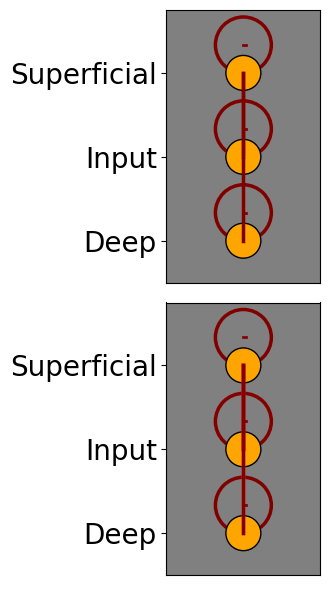

In [13]:
nLayers = 3
nPopulations = 1
nEpochs = 1
data_type = 'layeronly'

fig, ax = plt.subplots(2,1, figsize = (3,6),dpi = 100)

#Parameters for size and spacing of objects
node_radius = 0.25
layer_space = [4.4, 3.2, 2]
waveform_space = [0, -.5]
recurrent_node_radius = 0.4


#Set DAG background to gray
for row in range(2):
        ax[row].set_facecolor("gray")


#Draw populations (nodes)
for row in range(2): #True connectivity on top, dependency graph on bottom
        for waveform in [1]:
            for layer in [1,2,3]:
                draw_population(ax[row], waveform, layer)




# Draw connectivity edges
from_idx = 0
for from_layer in np.arange(1,nLayers+1):
    to_idx = 0
    for to_layer in np.arange(1,nLayers+1):
        #Attend In Edges    
        edge_weight = true_connectivity[from_idx,to_idx]
        print(edge_weight)

        if np.abs(edge_weight) != 0 :
            draw_edge(ax = ax[0],
                      edge_weight = edge_weight,
                      edge_thickness = 0.05,
                      from_layer = from_layer,
                      from_waveform = 1,
                      to_layer = to_layer,
                      to_waveform = 1,
                      AMI = True)

        to_idx +=1    
    from_idx+=1                
                
# Draw connectivity edges
from_idx = 0
for from_layer in np.arange(1,nLayers+1):
    to_idx = 0
    for to_layer in np.arange(1,nLayers+1):
        #Attend In Edges    
        edge_weight = sig_avg_dags[from_idx,to_idx]
        if np.abs(edge_weight) != 0 :
            draw_edge(ax = ax[1],
                      edge_weight = edge_weight,
                      edge_thickness = 0.05,
                      from_layer = from_layer,
                      from_waveform = 1,
                      to_layer = to_layer,
                      to_waveform = 1,
                      AMI = True)

        to_idx +=1    
    from_idx+=1
    
# Set axis range and add labels
for row in range(2):
    ax[row].set_xlim(-1.1,1.1)
    ax[row].set_ylim(1.4,5.3)
    ax[row].set_aspect('equal', adjustable='box')
    ax[row].set_xticks([])
    ax[row].axis = 'equal'
    ax[row].set_yticks(layer_space)
    ax[row].set_yticklabels(['Superficial','Input','Deep'], fontsize = 20) #Only need to do this for first plot

    
        
time_fontsize = 20
time_rotation = 45
# ax[0].set_title('-30 msec', fontsize = time_fontsize, rotation = time_rotation)
# ax[1].set_title('-15 msec', fontsize = time_fontsize, rotation = time_rotation)

fig.tight_layout()
plt.savefig("Figures/DAGs_pgmpy_laminar2_epoch1_{binWidth}ms_bins_{data_type}_lag{lag}.svg".format(binWidth = binWidth, data_type = data_type, lag = lag))


